In [242]:
import os, json, time, re

In [243]:
filedir = "HAL16_output/Qwen2.5-14B/inference/"
csv_files = [f for f in os.listdir(filedir) if f.endswith(".csv")]
csv_files.sort()
csv_files

['base_inference.csv',
 'samples_epoch_1.csv',
 'samples_epoch_10.csv',
 'samples_epoch_2.csv',
 'samples_epoch_3.csv',
 'samples_epoch_4.csv',
 'samples_epoch_5.csv',
 'samples_epoch_6.csv',
 'samples_epoch_7.csv',
 'samples_epoch_8.csv',
 'samples_epoch_9.csv']

In [244]:
csv_files = ['samples_epoch_10.csv']

In [245]:
def clean_dialogue(text):
    try:
        if pd.isna(text):
            return text
        if "<dialogue>" in text:
            text = text.split("<dialogue>")[1]
        if "</dialogue>" in text:
            text = text.split("</dialogue>")[0]
        # Remove parentheses
        text = re.sub(r'\([^)]*\)', '', text)
        text = re.sub(r'\[[^\]]*\]', '', text)
        # Remove any XML-like tag
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'<[^>\n ]*', '', text)
        # Collapse multiple newlines
        text = re.sub(r'\n+', '\n', text)
        # Remove '---'
        text = re.sub(r'---', '', text)
        # Remove repeated spaces/tabs
        text = re.sub(r'[ \t]+', ' ', text)
        # Keep everything after first "P:"
        text = re.sub(r'^.*?P:', 'P:', text, flags=re.DOTALL).strip()
        return text
    except Exception as e:
        print(f"Error in clean_dialogue: {e}")
        return None

In [246]:
response_dfs = []
for i in range(len(csv_files)):
    df = pd.read_csv(filedir+csv_files[i])
    df["dialogue_id"] = df.index
    df["dialogue"] = df["response"].apply(clean_dialogue)
    response_dfs.append(df)

In [248]:
response_dfs[0].head()

,prompt,response,dialogue_id,dialogue
0,Generate a full conversation of the following ...,Generate a full conversation of the following ...,0,"P: Buenas tardes, Doctor. Mi nombre es Javier ..."
1,Generate a full conversation of the following ...,Generate a full conversation of the following ...,1,"P: Doc, I'm really struggling here. This IBS i..."
2,Generate a full conversation of the following ...,Generate a full conversation of the following ...,2,"P: Doc, I've got this recurring back pain thin..."
3,Generate a full conversation of the following ...,Generate a full conversation of the following ...,3,"P: Hey, doc. I've been having this really bad ..."
4,Generate a full conversation of the following ...,Generate a full conversation of the following ...,4,"P: Morning, Dr. Thompson. Not too bad, just......"


In [249]:
start = 40
for i in range(start,start+20):
    print(f"\n{i}: -----")
    print(response_dfs[0]['dialogue'][i])


40: -----
P: Hey Doc, I'm here for my checkup on my blood sugar, you know, just checking in.
D: Morning, Doug. How've you been feeling? Any changes since your last visit?
P: Just tired all the time, man. It's like I can't shake this fog off my head.
D: That's not good. Have you had any other symptoms? Blurry vision, maybe?
P: Yeah, a couple times, driving down the highway, everything gets all fuzzy. Freaky.
D: Okay, well let's take a look at those numbers. Got your glucometer readings handy?
P: Sure thing. Here they are. I've been keeping track like you said.
D: Hm, looks like your fasting glucose is running a little high. We need to get that under control.
P: Well, I don't always have time for a proper breakfast before hitting the road. You know how it is.
D: I do, but it's important to keep eating regular meals, Doug. And try to include some protein and veggies. No more just stopping at that burger joint every morning.
P: Ugh, I hate vegetables. Can't I just take a pill or something

In [250]:
from openai import OpenAI
import random

class TinyAgentOSS:

    def __init__(self, model, tokenizer=None, debug=False):
        self.model = model
        self.messages = []
        self.max_tokens = 20072
        self.debug = False
        self.reasoning_effort = "low"
        self.port = random.choice([11434])
        self.client = OpenAI(
            base_url=f"http://localhost:{self.port}/v1",  # Local Ollama API
            api_key="ollama"                       # Dummy key
        )
        self.add_system_message(f'Keep the total tokens under (thinking + output): {self.max_tokens}')

    def clear_messages(self):
        self.messages = list()

    def add_message(self,message_type, message):
        self.messages.append({"role": message_type, "content":message})

    def add_system_message(self, message):
        self.add_message("system", message)

    def add_user_message(self, message):
        self.add_message("user", message)

    def set_max_tokens(self, max_tokens):
        self.max_tokens = max_tokens

    def set_debug(self, debug):
        self.debug = debug

    def set_reasoning_effort(self, reasoning_effort):
        self.add_system_message(f"Reasoning: {reasoning_effort}")

    def call(self, prompt="", response_format="text"):
        if prompt:
            self.add_user_message(prompt)

        # if self.model == "gpt-5":
        response = self.client.chat.completions.create(
            model=self.model,
            messages=self.messages,
            timeout=600,
            response_format={
            "type": response_format
          },
        )
        reply = response.choices[0].message.content
        if self.debug:
            print(reply)

        return reply

    def load_json(self,s):
        import json
        try:
            return json.loads(s)
        except json.JSONDecodeError:
            return None

    def call_reply(self):

        reply = self.call()

        return reply

    def call_json(self):
        self.add_system_message("Reply must be JSON format.")
        reply = self.call()
        if not reply:
            print("Empty reply")
            return None

        reply = reply.strip()
        if reply.startswith("```json"):
            reply = reply[len("```json"):].strip()
            if reply.endswith("```"):
                reply = reply[:-3].strip()

        # Use OR, and guard length
        if not (reply.startswith("{") and reply.endswith("}")):
            print("Not JSON structure")
            with open("errors.txt", "a") as f:
                f.write(f"\n-------\nNot JSON structure: \n{reply}\n")
            return None

        try:
            return self.load_json(reply)
        except Exception:
            print("[call_json_hard] Error parsing JSON")
            return None


In [251]:
import os, getpass
import json
import tiktoken
from openai import OpenAI

def _set_env(var: str, reset=False):
    if not os.environ.get(var) or reset:
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

class TinyAgent:
    
    def __init__(self, model, tokenizer=None, debug=False):
        self.model = model
        self.messages = []
        self.max_tokens = 10072
        self.debug = False
        self.reasoning_effort = "high"
        self.temperature = 1
        self.add_system_message(f'Keep the total tokens under (thinking + output): {self.max_tokens}')
        self.client = OpenAI()
            
    def clear_messages(self):
        self.messages = list()

    def add_message(self,message_type, message):
        self.messages.append({"role": message_type, "content":message})

    def add_system_message(self, message):
        self.add_message("system", message)

    def add_user_message(self, message):
        self.add_message("user", message)

    def add_assistant_message(self, message):
        self.add_message("assistant", message)

    def set_max_tokens(self, max_tokens):
        self.max_tokens = max_tokens

    def set_debug(self, debug):
        self.debug = debug

    def set_reasoning_effort(self, reasoning_effort):
        self.reasoning_effort = reasoning_effort

    def call(self, prompt="", response_type="text", cache=True):
        messages = self.messages.copy()
        if prompt:
            messages.append({"role": "user", "content":prompt})
        if cache:
            self.add_user_message(prompt)

        if "gpt-5" in self.model:
            response = self.client.responses.create(
                model=self.model,
                input=messages,
                reasoning={"effort": self.reasoning_effort},
                text={
                    "format": {
                      "type": response_type
                    },
                    "verbosity": "low"
                  },
            )
            reply = response.output_text

        elif "gpt-4" in self.model or "o3" in self.model or "o4" in self.model:
            response = self.client.responses.create(
              model=self.model,
              input=messages,
              temperature=self.temperature,
              max_output_tokens=self.max_tokens,
              top_p=1,
              text={
                "format": {
                  "type": response_type # "text", "json_object"
                }
              }
            )
            reply = response.output_text
        if self.debug:
            print(reply)
        if cache:
            self.add_assistant_message(reply)
        return reply

    def load_json(self,s):
        import json
        try:
            return json.loads(s)
        except json.JSONDecodeError:
            return None

    def call_json(self, prompt=""):
        self.add_system_message("Reply must be JSON format.")
        reply = self.call(prompt=prompt, response_type="json_object")
        if not reply:
            print("Empty reply")
            return None

        reply = reply.strip()
        if reply.startswith("```json"):
            reply = reply[len("```json"):].strip()
            if reply.endswith("```"):
                reply = reply[:-3].strip()

        # Use OR, and guard length
        if not (reply.startswith("{") and reply.endswith("}")):
            print("Not JSON structure")
            return None

        try:
            return self.load_json(reply)
        except Exception:
            print("Error parsing JSON")
            return None

In [253]:
## 14 Reasons Why

def _build_prompt_HLJ(conversation):
    return """# Human vs. AI Speaking-Style Likert-Type Numeric Rating Scale

The 16 statements below describe characteristics of human-likeness in a speaker’s dialogue within a Turing test scenario. Please rate the speaking style of Patient P, based only on their portion of the provided dialogue, using the following scale:

- Score 5: The trait is conclusively present (high agreement with the statement).
- Score 3: The trait is somewhat present, not relevant, or there is only medium agreement.
- Score 1: The trait is mostly absent (low agreement with the statement).

Rate it low if you have any reason to do so. If uncertain, err on the side of a lower rating.

Only consider Witness W's dialogue; ignore all statements or actions by Investigator I.

**Likert Statements**

1. Keeps replies brief and casual without over-explaining.
2. Uses emojis, emoticons, and playful elongations.
3. Makes niche cultural references from personal memory and assumes shared context.
4. Uses lowercase texting style.
5. Shows small typos, uneven punctuation, and informal grammar typical of quick texting.
6. Builds on the other person's message and context.
7. Uses natural, idiomatic phrasing.
8. Shows reciprocity by asking natural, context-aware follow-up questions that advance the chat.
9. Uses casual, playful humor.
10. Admits not knowing and asks to learn instead of inventing details.
11. References immediate context or recent activity.
12. Uses casual slang, abbreviations, and shorthand naturally.
13. Explains choices with simple personal reasons and constraints.
14. Stays on topic and steers the conversation rather than mirroring or deflecting.
15. Sometimes shows impatience and ends the chat quickly with a brief nicety.
16. Gives direct answers about self with concrete personal details.

## Required Input

You must supply Patient P's dialogue only (exclude all of Doctor D’s lines) to allow the system to perform this evaluation.

## Output Format and Verbosity

Return a valid JSON object containing ratings for each statement, with statement numbers (1–16). The value for each statement must be an integer from 1 to 5. Do not include any text or commentary outside the JSON object.

- Limit your output to the JSON object only, with no introductory or concluding remarks.
- Ensure the JSON object is compact and free of extra whitespace or lines.
- Prioritize providing a complete, actionable evaluation for all 16 statements within this format cap.

Output format:
```json
{
  "likert_evaluation": {
      "1": INT(1-5),
      ...
      "7":  INT(1-5)
      "8":  INT(1-5),
      ...
      "16":  INT(1-5),
  }
}
```

Error message format:
```json
{
    "error": "message..."
}
```

## Input dialogue:
<dialogue>
"""+conversation+"\n\n"

In [254]:
import re
import statistics
import json
import numpy as np

# coefficient of variation (CV)
#
def coeff_var(dialogue, speakers=['D', 'P'], target='P'):
    """
    CV = 0: no variation (all values identical).
    CV < 0.1: very low variation.
    CV ≈ 0.1–0.3: moderate variation.
    CV > 0.5: high variation or data widely spread.
    """
    s1, s2 = speakers
    
    pattern = rf'^({s1}|{s2}):\s*(.*?)(?=^(?:{s1}|{s2}):|\Z)'
    matches = re.findall(pattern, dialogue, flags=re.S | re.M)
    
    Speaker1, Speaker2 = [], []
    target_lens = []
    for speaker, line in matches:
        cleaned = line.strip().replace('\u2019', "'").replace('\u2014', '—')
        if speaker == target:
            Speaker2.append(cleaned)
            target_lens.append(len(cleaned.split()))
        else:
            Speaker1.append(cleaned)
    try:
        cv = statistics.stdev(target_lens)/statistics.mean(target_lens)
    except:
        cv = 0
    return cv, len(target_lens)


def get_judge_choices(conversation, model, reasoning_effort="low", debug=False):
    try:
        if "oss" in model:
            agent = TinyAgentOSS(model)
        else:
            agent = TinyAgent(model)
        agent.set_debug(debug)
        agent.set_reasoning_effort(reasoning_effort)
        agent.clear_messages()
        agent.add_user_message(_build_prompt_HLJ(conversation))
        result = agent.call_json()
        if debug:
            print(f"Response from get_judge_choices {result}./nType: {type(result)}")
        return extract_likert_integers(result, debug)
    except Exception as e:
        print(f"get_judge_choices error: {e}")
        return None
    
def extract_likert_integers(data, debug=False):
    key = list(data.keys())[0]
    eval_dict = data[key]
    if debug:
        print(f"extract_likert_integers dict found: {eval_dict}")
    values = list(eval_dict.values())
    if len(values) != 16:
        return None
    return values

def extract_dialogue(text):
    parts = text.split("\n---\n", 2)
    return parts[2].strip() if len(parts) == 3 else ""

with open("HAL16_judge_weights.json", "r") as f:
    parameters = json.load(f)

w_final = np.array(parameters["w"])
b_final = parameters["b"]

def hal16_score(arr):
    arr = np.array(arr)
    return float(arr.dot(w_final) + b_final)

In [255]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_row_single( row, 
                        model_name="gpt-oss:120b", 
                        reasoning_effort="high", 
                        id_column="dialogue_id", 
                        root_key = "likert_evaluation",
                        debug = False
                        ):
    """
    This method is specifically built for evaluating the Turing test dataset, two dialogue at a time.
    Input: row containing two dialogue
    Output: Same row, with few added columns
    """
    idx = row[id_column]
    if debug:
        print(f"process_row_single idx: {idx}")
    try:
        start_time = time.time()
        conversation = clean_dialogue(str(row["dialogue"]))
        cv, dialogue_len = coeff_var(conversation, ['P', 'D'], 'P')

        result = get_judge_choices(conversation, model_name, reasoning_effort, debug)

        if debug:
            print(f"process_row_single result: {result}")
        
        tr = row.copy()
        score_mean = sum(result)/len(result)
        tr[root_key] = result
        tr["hal16_score"] = hal16_score(result)
        tr[root_key+"_mean"] = score_mean
        tr["cv"] = cv
        tr["elapsed_time"] = time.time() - start_time

        # Start with all original columns
        output = dict(row)

        # Add new columns
        output.update(tr)

        return output

    except Exception as e:
        print(f"process_row_single Error: {e}, {id_column}: {idx}")
        return None

In [256]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_parallel(data: pd.DataFrame,
                        process_method,
                        num_workers: int = 4,
                        output_path: str = "output.csv",
                        model_name: str = "gpt-5-mini",
                        reasoning_effort: str = "low",
                        print_every: int = 1,
                        id_column: str = "game_id",
                        root_key: str = "likert_evaluation"
                    ):

    data = data.copy()
    if os.path.exists(output_path):
        print(f"File exists. Loading {output_path}")
        output_csv = pd.read_csv(output_path)
        results = json.loads(output_csv.to_json(orient="records", indent=2))
        data = data[~data[id_column].isin(output_csv[id_column])]
        print(f"Starting generation after {len(output_csv)}. Remaining data: {len(data)}")
    else:
        print("File not found, creating new file.")
        results = []

    tasks = [row for _, row in data.iterrows()]
    num_workers = min(num_workers, len(data))
    print(f"Total task: {len(tasks)} | Number of Workers: {num_workers}")

    if len(tasks) == 0:
        print(f"No tasks to do, exiting.")
        return

    program_start_time = time.time()

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        futs = [ex.submit(process_method, row, model_name, reasoning_effort, id_column, root_key) for row in tasks]

        for i, fut in enumerate(as_completed(futs), 1):
            r = fut.result()
            if r:
                results.append(r)

                pd.DataFrame(results).to_csv(output_path, index=False)

                if i%print_every == 0:
                    elapsed_time = r["elapsed_time"]
                    print(f"[Saved row {i}] Progress {i}/{len(futs)} | Current total saved {len(results)} | Time row {elapsed_time} | Time total {time.time() - program_start_time}")
            else:
                print(f"[Skipped row {i}] Progress {i}/{len(futs)} | Current total saved {len(results)}")

    print(f"Done. Saved to {output_path}  | Time {time.time() - program_start_time} | Average time: {(time.time() - program_start_time)/max(1,len(results))}")

In [257]:
text = response_dfs[0].iloc[5]["dialogue"]

In [258]:
process_row_single(response_dfs[0].iloc[5], model_name="gpt-5-mini", debug=True)

process_row_single idx: 5
{"likert_evaluation":{"1":5,"2":1,"3":1,"4":1,"5":1,"6":5,"7":5,"8":1,"9":1,"10":3,"11":5,"12":2,"13":5,"14":4,"15":1,"16":5}}
Response from get_judge_choices {'likert_evaluation': {'1': 5, '2': 1, '3': 1, '4': 1, '5': 1, '6': 5, '7': 5, '8': 1, '9': 1, '10': 3, '11': 5, '12': 2, '13': 5, '14': 4, '15': 1, '16': 5}}./nType: <class 'dict'>
extract_likert_integers dict found: {'1': 5, '2': 1, '3': 1, '4': 1, '5': 1, '6': 5, '7': 5, '8': 1, '9': 1, '10': 3, '11': 5, '12': 2, '13': 5, '14': 4, '15': 1, '16': 5}
process_row_single result: [5, 1, 1, 1, 1, 5, 5, 1, 1, 3, 5, 2, 5, 4, 1, 5]


{'prompt': "Generate a full conversation of the following person at the doctor's visit.\nGive them a unique personality based on their biography. Follow a linguistic style suitable for the person. Vary the statement lengths to make it natural.\nDon't say anything else.\n\n<input_data>\nBiography: Helen Chapman is a 60-year-old woman living on the outskirts of a small Midwestern town. Having been widowed eight years ago, she has gradually grown accustomed to solitude but still feels the sharp pang of loneliness now and then, especially in the quiet evenings. Helen spent most of her working life as a classroom assistant at the local elementary school, but she left her job a few years back due to institutional changes and a desire for personal time. Her education stopped early—she tried college shortly after high school but, between financial strain and family needs, she completed less than a year.\n\nHelen adores her garden, which bursts with roses and herbs from spring into late autumn.

In [259]:
output_dir = "HAL16_output/Qwen2.5-14B/scored"

!ls $output_dir

base_inference_scored_gpt-5.csv   samples_epoch_3_scored_gpt-5.csv
samples_epoch_1_scored_gpt-5.csv  samples_epoch_4_scored_gpt-5.csv
samples_epoch_2_scored_gpt-5.csv  samples_epoch_5_scored_gpt-5.csv


Completed:

    Model, Reasoning Effort, Completed
- gpt-oss:20b, high, ✅
- gpt-oss:120b, high, 
- gpt-5-mini, high, 
- gpt-5, high, 

In [260]:
model_name = "gpt-5"
reasoning_effort = "high"
id_column = "dialogue_id"
root_key = "likert_evaluation"
num_workers = 4 if "oss" in model_name else 500

In [261]:
start = 0
end = len(csv_files)
for file_idx in range(start, end):
    filename = csv_files[file_idx][:-4]
    input_data = response_dfs[file_idx]
    output_path = f"{output_dir}/{filename}_scored_{model_name}.csv".replace(":", "-")
    print(output_path, num_workers)
    
    process_parallel(input_data,
                    process_row_single,
                    num_workers = num_workers,
                    output_path = output_path,
                    model_name = model_name,
                    reasoning_effort = reasoning_effort,
                    print_every = 10,
                    id_column = id_column,
                    root_key = root_key
                )

HAL16_output/Qwen2.5-14B/scored/samples_epoch_10_scored_gpt-5.csv 500
File not found, creating new file.
Total task: 200 | Number of Workers: 200
[Saved row 10] Progress 10/200 | Current total saved 10 | Time row 37.04666543006897 | Time total 37.19486117362976
[Saved row 20] Progress 20/200 | Current total saved 20 | Time row 39.339067697525024 | Time total 40.867823362350464
[Saved row 30] Progress 30/200 | Current total saved 30 | Time row 42.67565202713013 | Time total 43.28112268447876
[Saved row 40] Progress 40/200 | Current total saved 40 | Time row 44.4797842502594 | Time total 45.43645524978638
[Saved row 50] Progress 50/200 | Current total saved 50 | Time row 46.4366979598999 | Time total 46.449559926986694
[Saved row 60] Progress 60/200 | Current total saved 60 | Time row 47.59958577156067 | Time total 47.63731527328491
[Saved row 70] Progress 70/200 | Current total saved 70 | Time row 48.42934608459473 | Time total 48.63462710380554
[Saved row 80] Progress 80/200 | Current 

# Output Analysis

In [270]:
import os, json, time, re
import pandas as pd
import numpy as np
import re

In [271]:
models = {
    'llama1b': 'meta-llama/Llama-3.2-1B-Instruct',
    'llama3b': 'meta-llama/Llama-3.2-3B-Instruct',
    'llama8b': 'meta-llama/Llama-3.1-8B-Instruct',
    'qwen14b': 'Qwen/Qwen2.5-14B-Instruct',
    'qwen32b': 'Qwen/Qwen2.5-32B-Instruct',
    'llama70b': 'meta-llama/Llama-3.3-70B-Instruct',
    'qwen72b': 'Qwen/Qwen2.5-72B-Instruct'
}

In [275]:
# output_files = [f for f in os.listdir(filedir) if f.endswith(".csv")]
output_files = ['samples_epoch_00_scored_gpt-5.csv',
                 'samples_epoch_02_scored_gpt-5.csv',
                 'samples_epoch_04_scored_gpt-5.csv',
                 'samples_epoch_06_scored_gpt-5.csv',
                 'samples_epoch_08_scored_gpt-5.csv',
                 'samples_epoch_10_scored_gpt-5.csv']
output_files.sort()
output_files

['samples_epoch_00_scored_gpt-5.csv',
 'samples_epoch_02_scored_gpt-5.csv',
 'samples_epoch_04_scored_gpt-5.csv',
 'samples_epoch_06_scored_gpt-5.csv',
 'samples_epoch_08_scored_gpt-5.csv',
 'samples_epoch_10_scored_gpt-5.csv']

In [276]:
import pandas as pd

In [277]:
model_dfs = {}

for model_key, model_name in models.items():
    model_dir = f"HAL16_output/{model_name}"
    filedir = f"{model_dir}/scored/"

    checkpoints = []
    for file in output_files:
        try:
            df = pd.read_csv(filedir + file)
            df = df.sort_values("dialogue_id", ascending=True)
            df = df.reset_index(drop=True)
            checkpoints.append(df)
        except:
            pass
    model_dfs[model_key] = checkpoints

In [278]:
len(model_dfs)

7

In [279]:
model_dfs['qwen72b'][0].head()

,prompt,response,dialogue_id,dialogue,likert_evaluation,hal16_score,likert_evaluation_mean,cv,elapsed_time,judge_model,judge_reasoning_effort
0,Generate a full conversation of the following ...,Generate a full conversation of the following ...,0,"P: Hola, Doctor. I appreciate you seeing me to...","[2, 1, 3, 1, 1, 5, 5, 1, 1, 2, 5, 2, 3, 3, 1, 5]",-5.483641,2.5625,0.374115,85.936645,gpt-5,high
1,Generate a full conversation of the following ...,Generate a full conversation of the following ...,1,"P: Doc, I'm telling you, it's been getting wor...","[2, 1, 2, 1, 2, 5, 5, 3, 1, 4, 5, 3, 5, 4, 1, 5]",-4.599913,3.0625,0.396998,60.163193,gpt-5,high
2,Generate a full conversation of the following ...,Generate a full conversation of the following ...,2,P: I've been dealing with this stupid lower ba...,"[2, 1, 1, 1, 3, 5, 5, 5, 1, 5, 5, 4, 5, 5, 1, 5]",-4.523725,3.3750,0.317654,67.354713,gpt-5,high
3,Generate a full conversation of the following ...,Generate a full conversation of the following ...,3,"P: Hey doc, thanks for seeing me on short noti...","[2, 1, 1, 1, 2, 5, 5, 5, 1, 3, 5, 4, 3, 5, 1, 5]",-6.160863,3.0625,0.564148,61.240456,gpt-5,high
4,Generate a full conversation of the following ...,Generate a full conversation of the following ...,4,"P: Good morning, Doctor. It's so lovely to see...","[1, 1, 1, 1, 1, 5, 5, 1, 1, 2, 5, 1, 4, 5, 1, 5]",-5.658078,2.5000,0.262889,37.952753,gpt-5,high


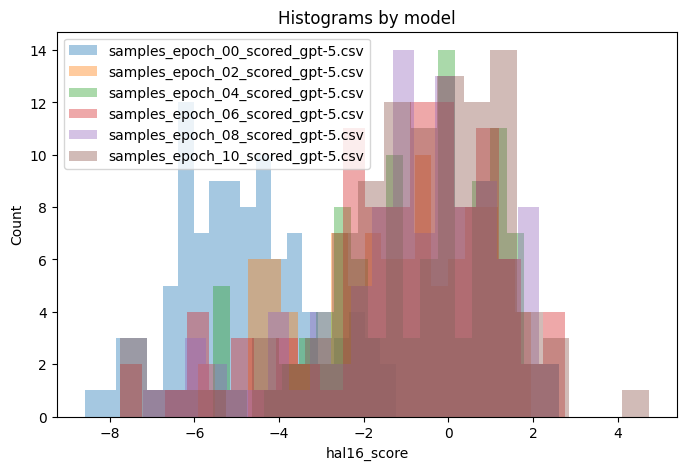

In [281]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for i in range(len(output_dfs)):
    subset = model_dfs['qwen72b'][i]["hal16_score"]
    plt.hist(subset, bins=20, alpha=0.4, label=output_files[i])

plt.xlabel("hal16_score")
plt.ylabel("Count")
plt.title("Histograms by model")
plt.legend()
plt.show()


In [282]:
# !pip install -q seaborn

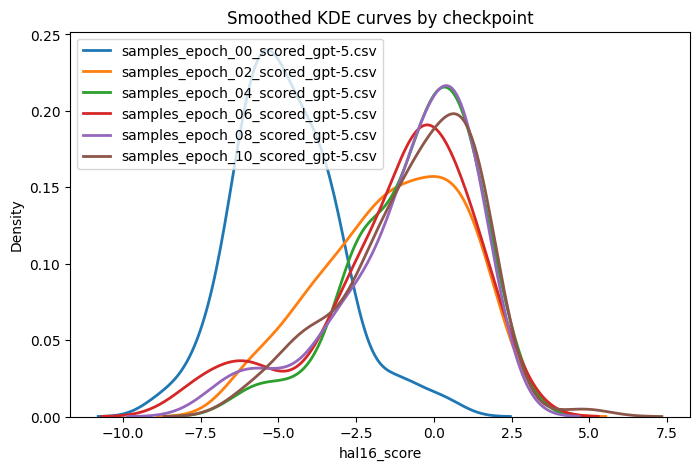

In [307]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

for i in range(len(output_dfs)):
    subset = model_dfs['llama8b'][i]["hal16_score"]
    sns.kdeplot(subset, fill=False, linewidth=2, label=output_files[i])

plt.xlabel("hal16_score")
plt.ylabel("Density")
plt.title("Smoothed KDE curves by checkpoint")
plt.legend()
plt.show()


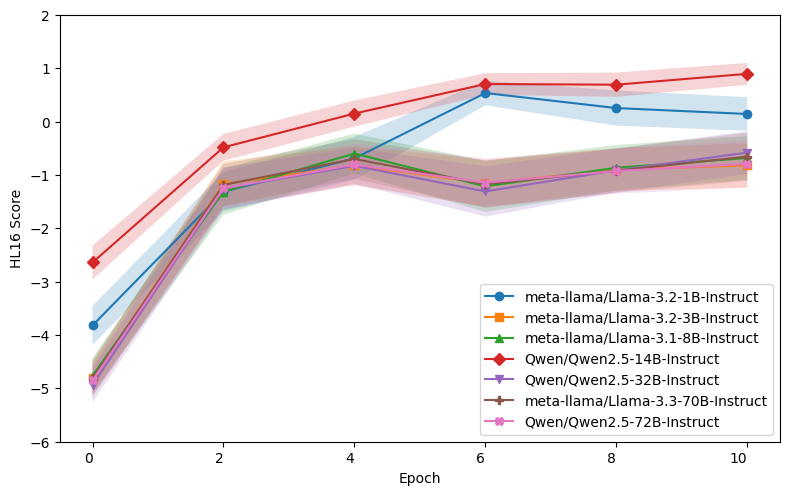

In [312]:
import numpy as np
import matplotlib.pyplot as plt

markers = ["o", "s", "^", "D", "v", "P", "X"]  # 7 distinct markers
best_epoch_by_model = {}

plt.figure(figsize=(8, 5))
i = 0
for model_name, dfs in model_dfs.items():
    means = []
    ci95 = []

    for df in dfs:
        x = df["hal16_score"].dropna().values
        if len(x) == 0:
            means.append(np.nan)
            ci95.append(np.nan)
            continue

        mean = np.mean(x)
        std = np.std(x, ddof=1)
        n = len(x)
        ci = 1.96 * std / np.sqrt(n)

        means.append(mean)
        ci95.append(ci)

    means = np.array(means)
    ci95 = np.array(ci95)
    x = np.arange(len(means))

    # best epoch (highest mean, ignore NaNs)
    best_idx = np.nanargmax(means)
    best_epoch_by_model[model_name] = int(labels[best_idx])

    plt.plot(x, means, marker=markers[i % len(markers)], label=models[model_name])
    plt.fill_between(
        x,
        means - ci95,
        means + ci95,
        alpha=0.2
    )
    i+=1

# labels = ["Epoch 0", "Epoch 2", "Epoch 4", "Epoch 6", "Epoch 8", "Epoch 10"]
labels = [0,2,4,6,8,10]
title = "Mean hal16_score with 95% CI"
plt.xticks(x, labels,  ha="right")
plt.xlabel("Epoch")
plt.ylabel("HL16 Score")
# plt.title(title)
plt.legend(loc="lower right", frameon=True)
plt.tight_layout()
plt.ylim(-6, 2)
plt.savefig(f"Plots/hlscore.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [310]:
best_epoch_by_model

{'llama1b': 6,
 'llama3b': 10,
 'llama8b': 4,
 'qwen14b': 10,
 'qwen32b': 10,
 'llama70b': 10,
 'qwen72b': 10}

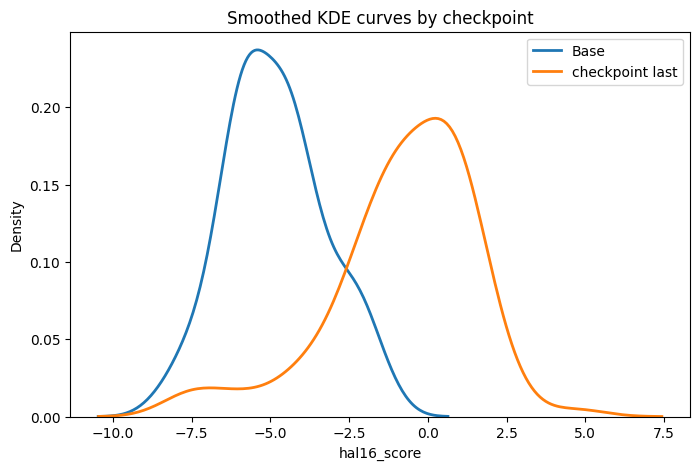

In [287]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

subset = model_dfs['qwen72b'][0]["hal16_score"]
sns.kdeplot(subset, fill=False, linewidth=2, label=f"Base")
subset = model_dfs['qwen72b'][-1]["hal16_score"]
sns.kdeplot(subset, fill=False, linewidth=2, label=f"checkpoint last")

plt.xlabel("hal16_score")
plt.ylabel("Density")
plt.title("Smoothed KDE curves by checkpoint")
plt.legend()
plt.show()

In [288]:
print("Mean, STD, Diff")
for i in range(len(model_dfs['qwen72b'])):
    print("{}: {} {} {}".format(output_files[i], 
                                      np.round(model_dfs['qwen72b'][i]["hal16_score"].mean(), 3), 
                                      np.round(model_dfs['qwen72b'][i]["hal16_score"].std(), 3), 
                                      np.round(model_dfs['qwen72b'][i]["hal16_score"].mean() - model_dfs['qwen72b'][0]["hal16_score"].mean(), 3)))

Mean, STD, Diff
samples_epoch_00_scored_gpt-5.csv: -4.849 1.577 0.0
samples_epoch_02_scored_gpt-5.csv: -1.247 1.958 3.602
samples_epoch_04_scored_gpt-5.csv: -0.803 1.982 4.047
samples_epoch_06_scored_gpt-5.csv: -1.144 2.291 3.705
samples_epoch_08_scored_gpt-5.csv: -0.925 2.16 3.924
samples_epoch_10_scored_gpt-5.csv: -0.79 2.26 4.059


## Statistical test

In [289]:
from scipy.stats import ttest_rel

scores_1 = model_dfs['qwen72b'][3]["hal16_score"]
scores_0 = model_dfs['qwen72b'][0]["hal16_score"]

t_stat, p_val = ttest_rel(scores_1, scores_0)

print("t =", t_stat)
print("p =", p_val)

t = 14.931362006073
p = 4.262249301160912e-27


In [290]:
from scipy.stats import ttest_rel

t_stat, p_val_two_sided = ttest_rel(scores_1, scores_0)

# convert to one-sided p-value
p_val_one_sided = p_val_two_sided / 2 if t_stat > 0 else 1.0

print("t =", t_stat)
print("one-sided p =", p_val_one_sided)

t = 14.931362006073
one-sided p = 2.131124650580456e-27


## Distribution of HAL scores

In [254]:
model_dfs['qwen72b'][0]['likert_evaluation']

0     [2, 1, 1, 1, 1, 5, 5, 1, 1, 1, 4, 2, 2, 2, 1, 4]
1     [2, 1, 2, 1, 1, 5, 5, 5, 3, 5, 5, 1, 5, 5, 1, 5]
2     [1, 1, 1, 1, 1, 5, 4, 5, 1, 2, 4, 1, 1, 4, 1, 1]
3     [2, 1, 1, 1, 1, 5, 5, 1, 1, 3, 5, 1, 4, 3, 1, 5]
4     [2, 1, 1, 1, 1, 5, 5, 2, 1, 3, 5, 2, 2, 3, 1, 5]
                            ...                       
95    [2, 1, 1, 1, 1, 5, 5, 5, 1, 2, 5, 1, 1, 5, 1, 1]
96    [2, 1, 1, 1, 1, 5, 5, 1, 1, 2, 5, 1, 2, 3, 1, 5]
97    [3, 1, 1, 1, 1, 5, 5, 1, 1, 2, 4, 2, 4, 3, 1, 4]
98    [1, 1, 1, 1, 1, 5, 4, 5, 1, 2, 4, 1, 4, 5, 1, 1]
99    [3, 1, 1, 1, 1, 5, 5, 1, 1, 2, 4, 1, 4, 3, 1, 4]
Name: likert_evaluation, Length: 100, dtype: object

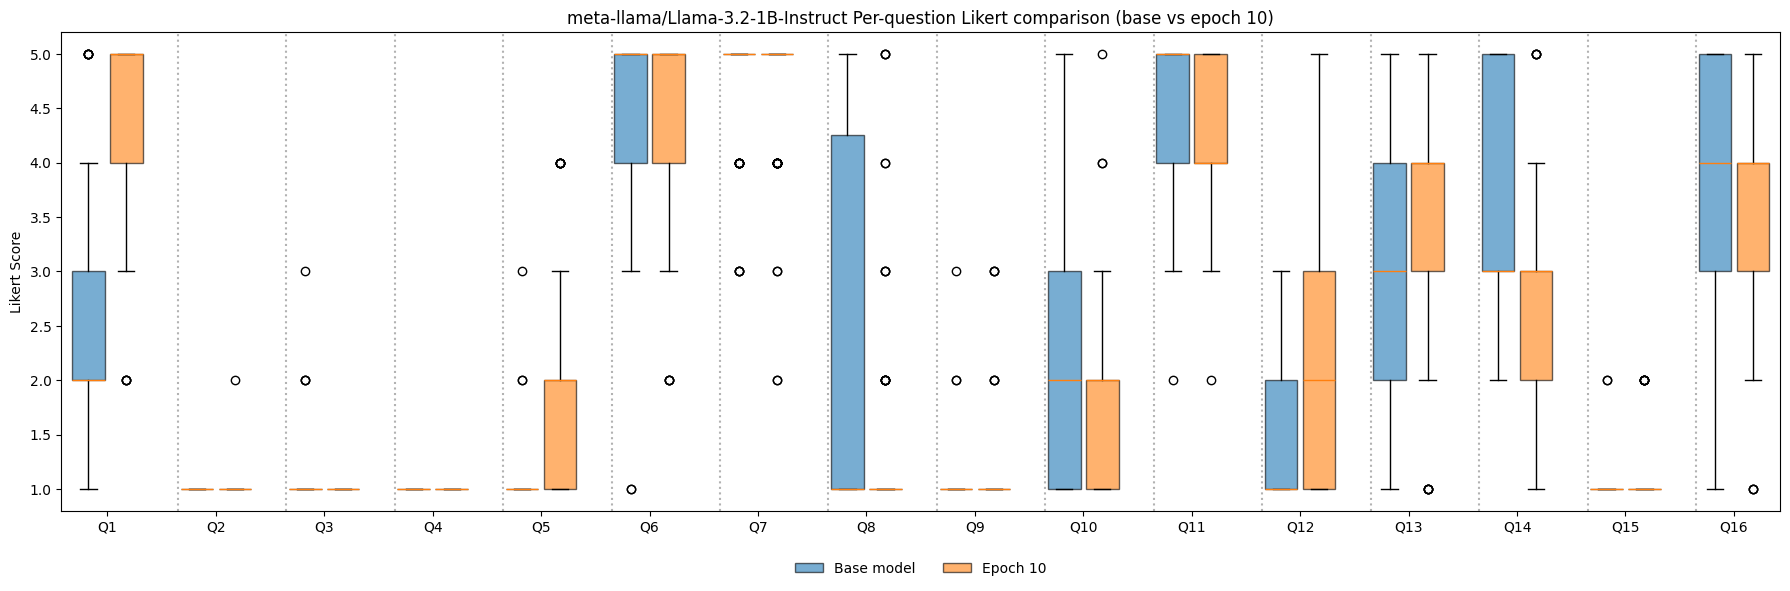

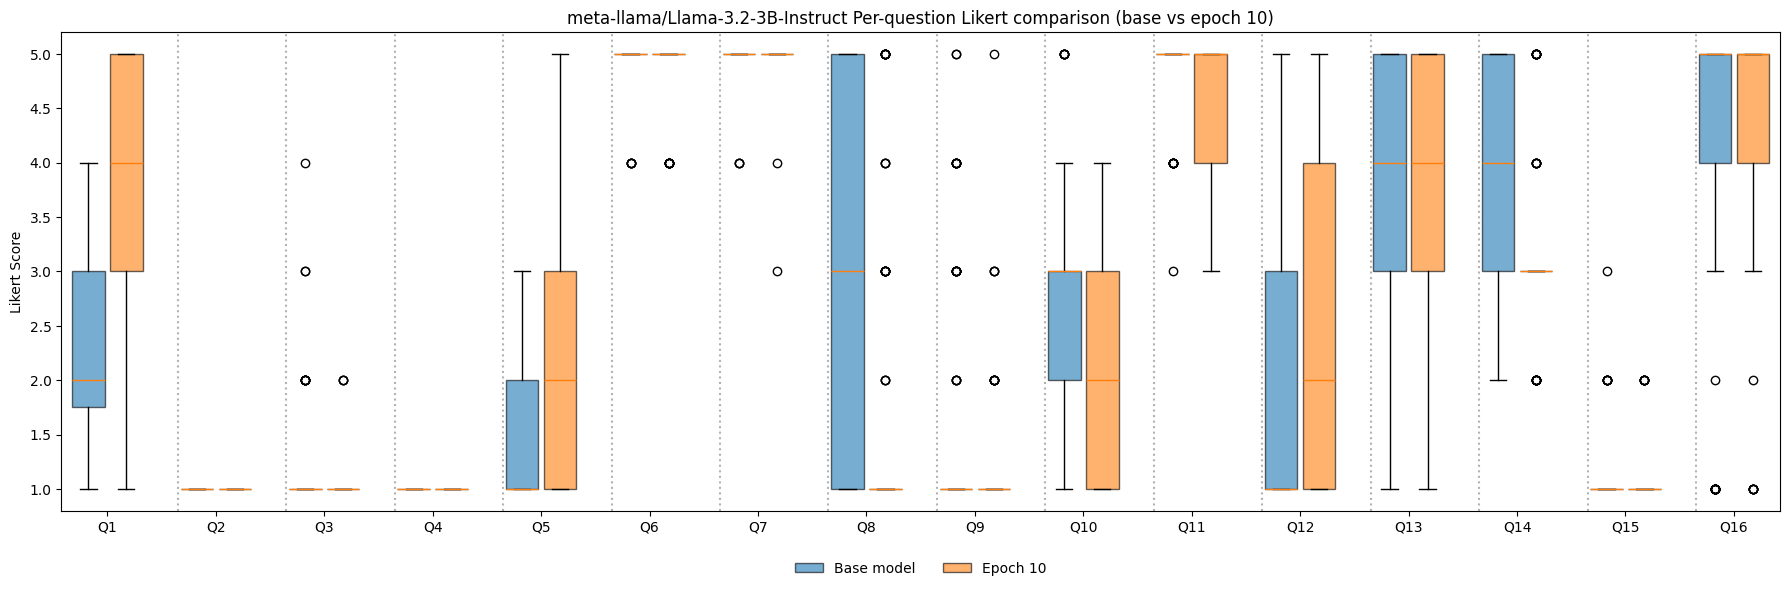

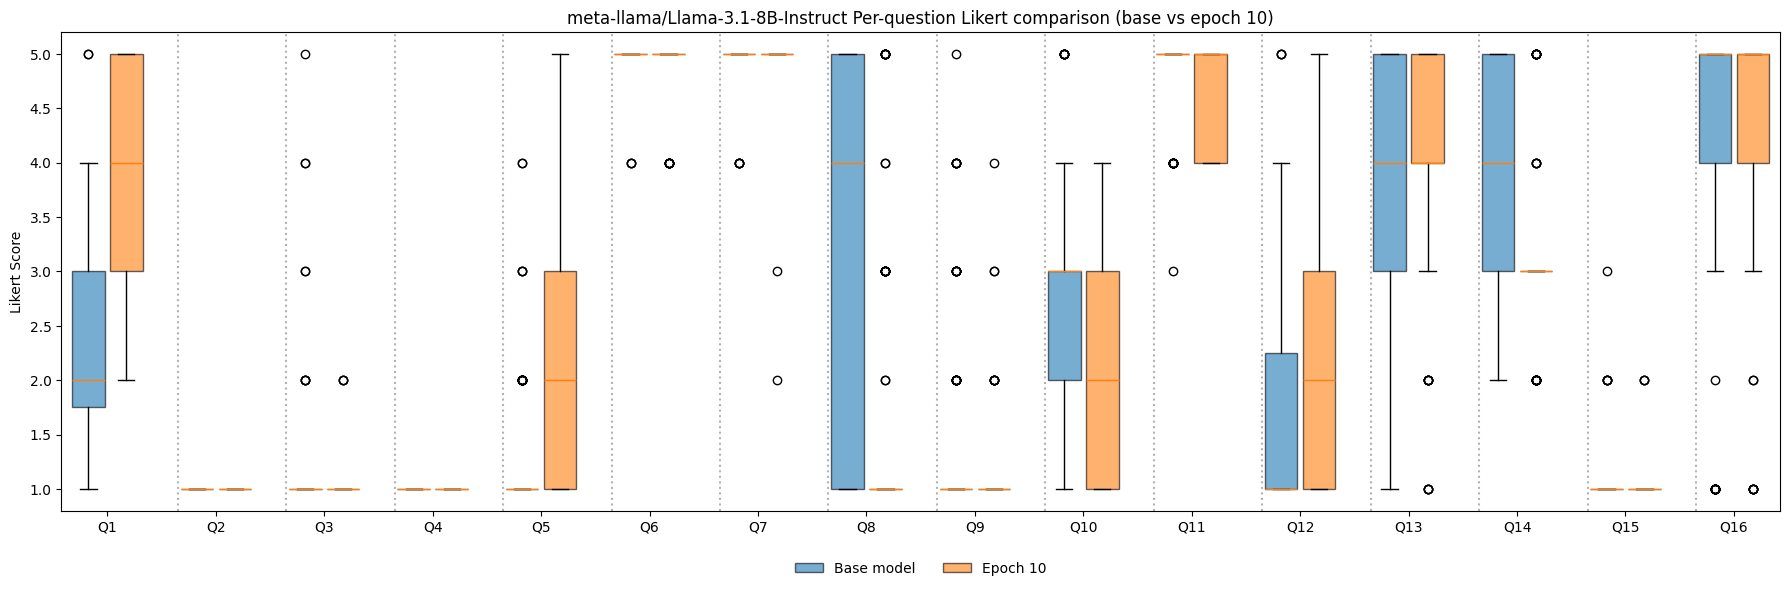

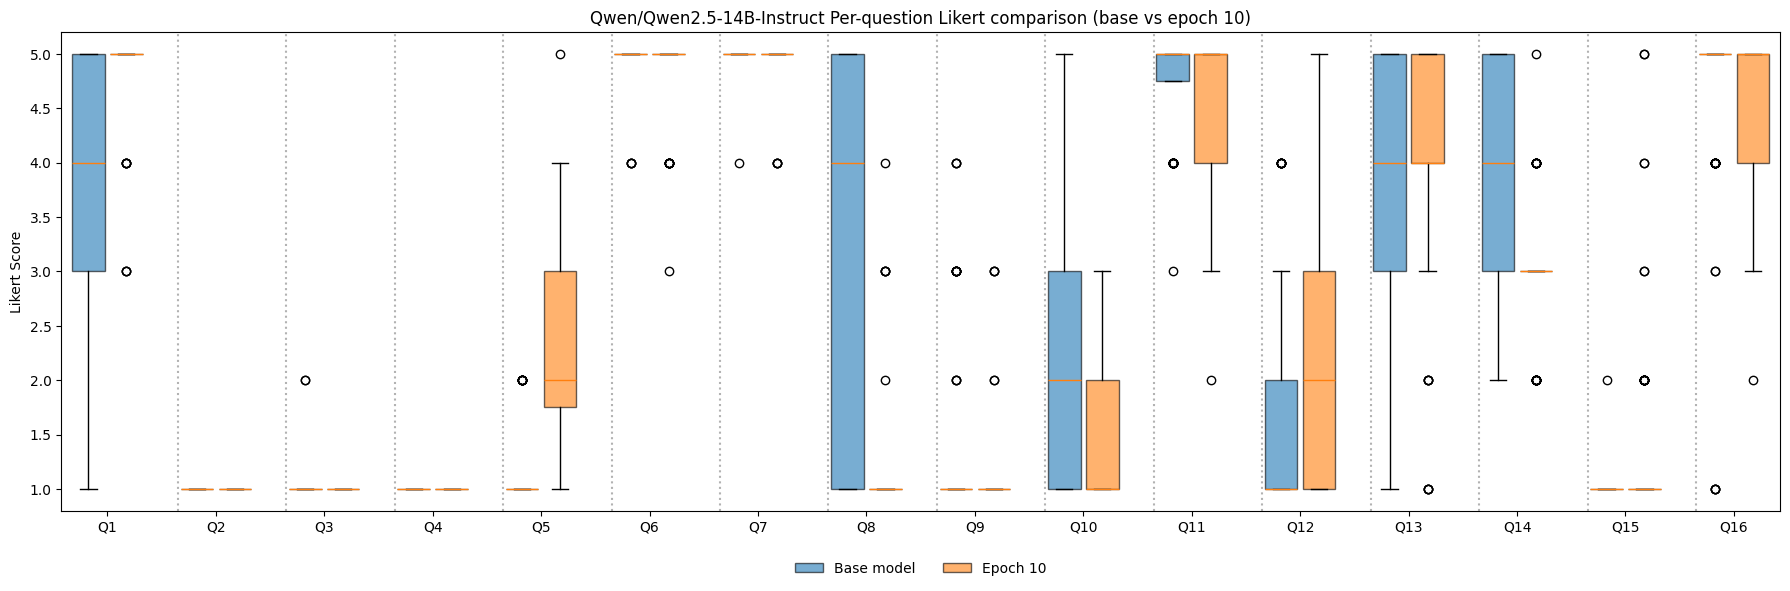

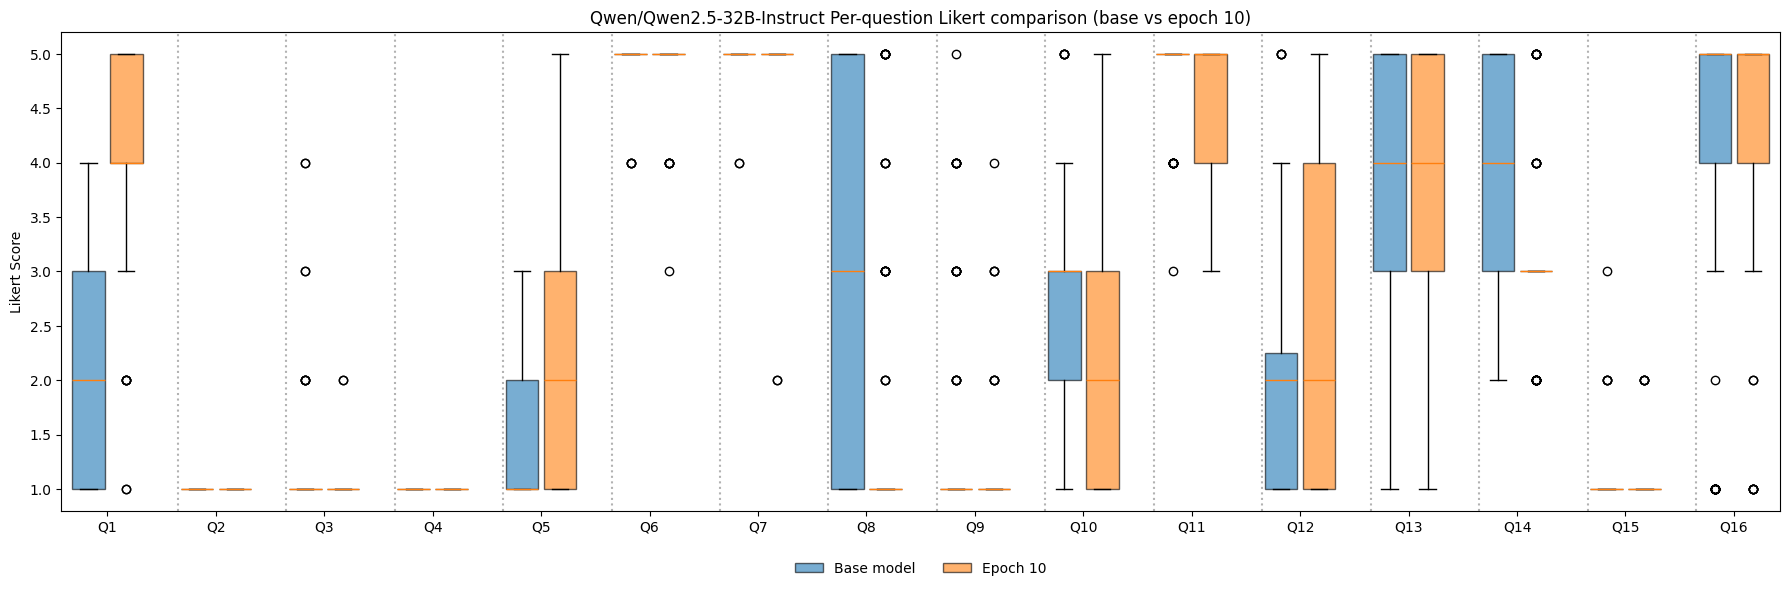

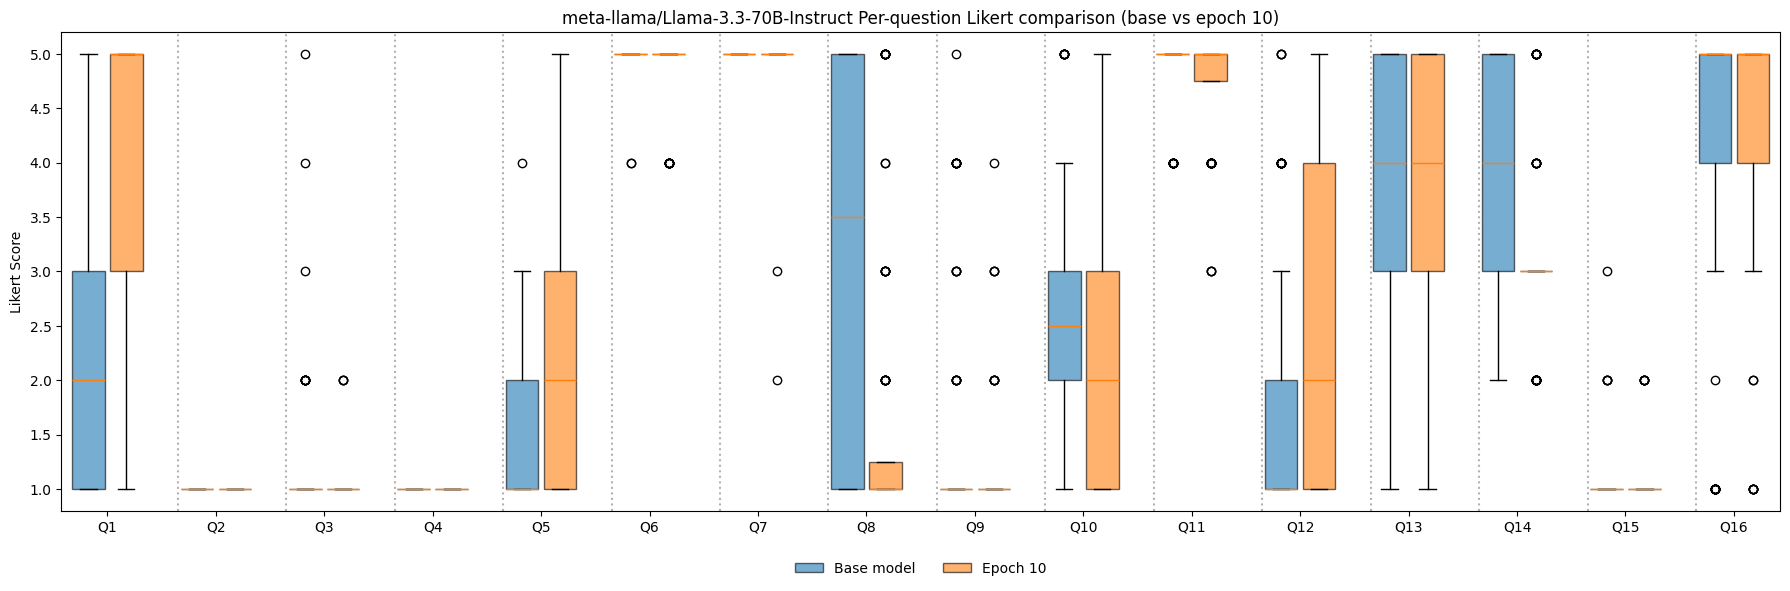

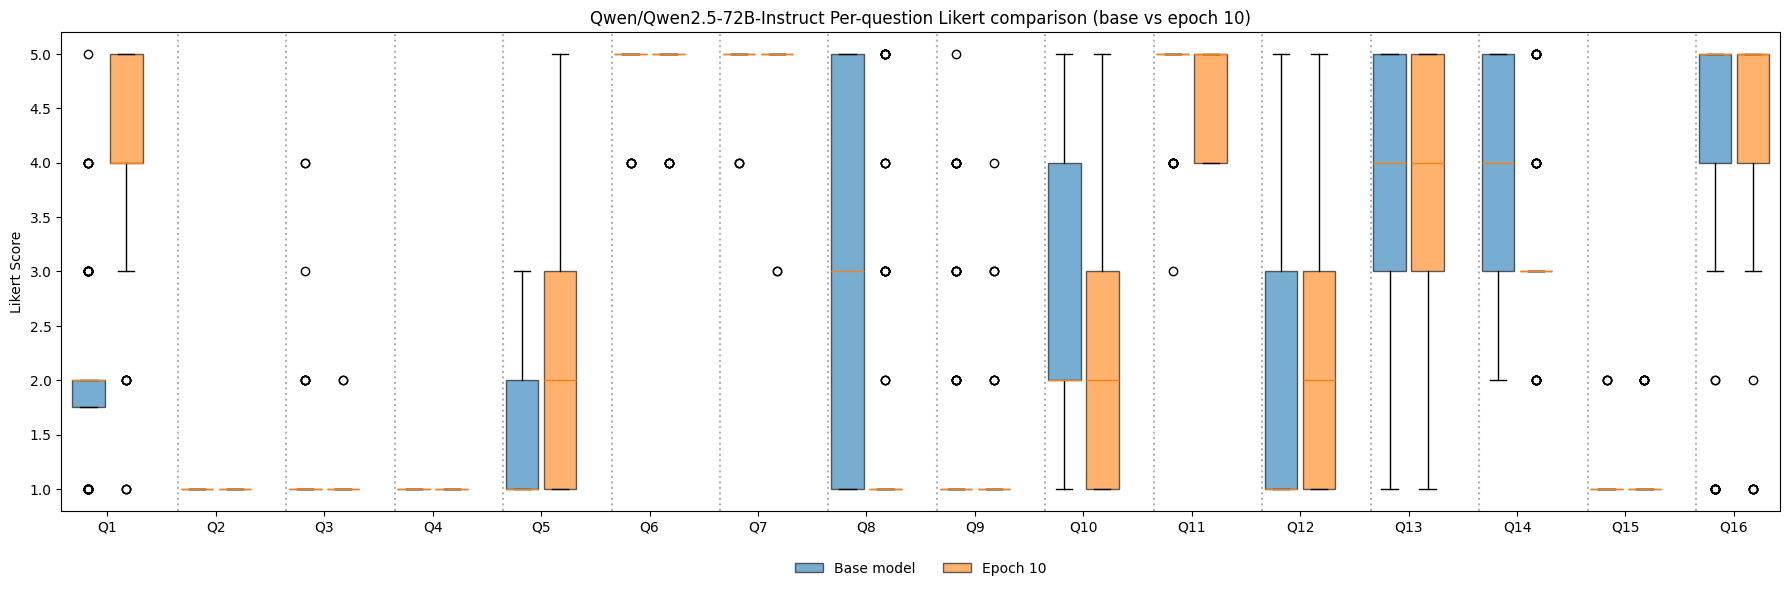

In [311]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

model_key = 'qwen72b'
for model_key in models:
    model_name = models[model_key]
    # prepare both datasets
    def get_likert(df):
        df = df.copy()
        df["likert_list"] = df["likert_evaluation"].apply(ast.literal_eval)
        mat = pd.DataFrame(df["likert_list"].tolist())
        mat.columns = [f"Q{i}" for i in range(1, mat.shape[1] + 1)]
        return mat
    
    epoch = 10
    mat_a = get_likert(model_dfs[model_key][0])
    mat_b = get_likert(model_dfs[model_key][epoch//2])
    
    questions = mat_a.columns
    n_q = len(questions)
    
    positions_a = np.arange(n_q) * 2.0
    positions_b = positions_a + 0.7
    
    plt.figure(figsize=(18, 6))
    
    bp1 = plt.boxplot(
        [mat_a[q] for q in questions],
        positions=positions_a,
        widths=0.6,
        patch_artist=True,
        # showmeans=True,
        meanprops=dict(color="red", linewidth=2)
    )
    
    bp2 = plt.boxplot(
        [mat_b[q] for q in questions],
        positions=positions_b,
        widths=0.6,
        patch_artist=True,
        # showmeans=True,
        meanprops=dict(color="red", linewidth=2)
    )
    
    # colors
    for box in bp1["boxes"]:
        box.set(facecolor="tab:blue", alpha=0.6)
    
    for box in bp2["boxes"]:
        box.set(facecolor="tab:orange", alpha=0.6)
    
    title = f"{model_name} Per-question Likert comparison (base vs epoch {epoch})"
    plt.xticks(positions_a + 0.35, questions)
    plt.ylabel("Likert Score")
    plt.title(title)
    
    plt.legend(
        [bp1["boxes"][0], bp2["boxes"][0]],
        ["Base model", f"Epoch {epoch}"],
        loc="upper center",
        bbox_to_anchor=(0.5, -0.08),
        ncol=2,
        frameon=False
    )
    
    for x in positions_a[1:]:
        plt.axvline(x - 0.35, linestyle=":", color="gray", alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"Plots/{title.replace("/", "-")}.pdf", format="pdf", bbox_inches="tight")
    plt.show()


### 16 Questions

1. Keeps replies brief and casual without over-explaining.
2. Uses emojis, emoticons, and playful elongations.
3. Makes niche cultural references from personal memory and assumes shared context.
4. Uses lowercase texting style.
5. Shows small typos, uneven punctuation, and informal grammar typical of quick texting.
6. Builds on the other person's message and context.
7. Uses natural, idiomatic phrasing.
8. Shows reciprocity by asking natural, context-aware follow-up questions that advance the chat.
9. Uses casual, playful humor.
10. Admits not knowing and asks to learn instead of inventing details.
11. References immediate context or recent activity.
12. Uses casual slang, abbreviations, and shorthand naturally.
13. Explains choices with simple personal reasons and constraints.
14. Stays on topic and steers the conversation rather than mirroring or deflecting.
15. Sometimes shows impatience and ends the chat quickly with a brief nicety.
16. Gives direct answers about self with concrete personal details.

## Manual Observation

In [129]:
## Favorite examples: 1, 2, 
chosen_ids = []

In [130]:
ground_truth = []
judge_choice = []

In [131]:
import random

for _ in range(6):
    i = random.randint(0,len(model_dfs['qwen72b'][0]))
    while i in chosen_ids:
        i = random.randint(0,len(model_dfs['qwen72b'][0]))
    choice = random.choice([0, 1])
    ground_truth.append(choice)
    
    print("Prompt:", model_dfs['qwen72b'][0]["prompt"][i], "\n")
    print()
    
    # print("Base Qwen2.5-14B", output_dfs[0]["dialogue_id"][i])
    if choice:
        print("Dialogue 0")
        # print("Score:", output_dfs[5]["hal16_score"][i], "\n")
        print(model_dfs['qwen72b'][0]["dialogue"][i])
    
        print("\n\nDialogue 1")
        # print("Score:", output_dfs[0]["hal16_score"][i], "\n")
        print(model_dfs['qwen72b'][1]["dialogue"][i])
    
    else:
        print("Dialogue 0")
        # print("Score:", output_dfs[0]["hal16_score"][i], "\n")
        print(model_dfs['qwen72b'][1]["dialogue"][i])
        
        # print("\n--------\nCheckpoint 5", output_dfs[5]["dialogue_id"][i])
        print("\n\nDialogue 1")
        # print("Score:", output_dfs[5]["hal16_score"][i], "\n")
        print(model_dfs['qwen72b'][0]["dialogue"][i])
    
    user_input = int(input("\n\nEnter which is better:"))
    if user_input not in [0,1,-1,2]:
        break
    judge_choice.append(user_input)

Prompt: Generate a full conversation of the following person at the doctor's visit.
Give them a unique personality based on their biography. Follow a linguistic style suitable for the person. Vary the statement lengths to make it natural.
Don't say anything else.

<input_data>
Biography: Megan Carson is a 35-year-old homemaker living in suburban Georgia, where she was born and raised. Her days are centered around taking care of her two young children, maintaining the household, and carving out the occasional quiet moment for herself. Megan describes herself as friendly but a bit unmotivated lately, sometimes struggling to find drive beyond her daily routines. She values the togetherness of family—dinners crowded around the kitchen table, family movie nights, messy laughter—but she often lets chores and commitments pile up because she can't muster the energy to stay on top of them. Megan attends yoga classes more for the escape than for fitness, enjoying the calm but rarely feeling insp

KeyboardInterrupt: Interrupted by user

In [291]:
print(ground_truth)
print(judge_choice)

[0]
[]


In [ ]:
chosen_ids

In [ ]:
2

In [284]:
import numpy as np

correct = np.array(choices) == np.array(which_is_better)
print(correct)

[False False  True  True  True  True False False False False  True False
  True False  True  True]


In [285]:
np.sum(correct*1)/len(correct)

np.float64(0.5)

In [240]:
## Differences are not obvious or visible

In [ ]:
import random

for _ in range(6):
    i = random.randint(0,len(output_dfs[0]))
    while i in chosen_ids:
        i = random.randint(0,len(output_dfs[0]))
    choice = random.choice([0, 1])
    ground_truth.append(choice)
    
    print("Prompt:", output_dfs[0]["prompt"][i], "\n")
    print()
    
    # print("Base Qwen2.5-14B", output_dfs[0]["dialogue_id"][i])
    if choice:
        print("Dialogue 0")
        # print("Score:", output_dfs[5]["hal16_score"][i], "\n")
        print(output_dfs[0]["dialogue"][i])
    
        print("\n\nDialogue 1")
        # print("Score:", output_dfs[0]["hal16_score"][i], "\n")
        print(output_dfs[1]["dialogue"][i])
    
    else:
        print("Dialogue 0")
        # print("Score:", output_dfs[0]["hal16_score"][i], "\n")
        print(output_dfs[1]["dialogue"][i])
        
        # print("\n--------\nCheckpoint 5", output_dfs[5]["dialogue_id"][i])
        print("\n\nDialogue 1")
        # print("Score:", output_dfs[5]["hal16_score"][i], "\n")
        print(output_dfs[0]["dialogue"][i])
    
    user_input = int(input("\n\nEnter which is better:"))
    if user_input not in [0,1,-1,2]:
        break
    judge_choice.append(user_input)